# Load images to be used for training

Number of car images in labeled data set: 8792
Number of not car images in labeled data set: 8968


Text(0.5, 1.0, 'not car')

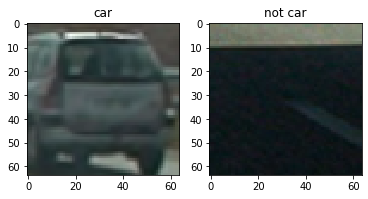

In [1]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def get_images_in_dir(dir):
    l = []
    for path, subdirs, files in os.walk(dir):
        for name in files:
            if name.endswith('.png'):
                l.append(os.path.join(path, name))                
    return l
                
car_list = get_images_in_dir("labeled_images/vehicles")
not_car_list = get_images_in_dir("labeled_images/non_vehicles")

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

data_dict = data_look(car_list, not_car_list)
print("Number of car images in labeled data set: " + str(data_dict["n_cars"]))
print("Number of not car images in labeled data set: " + str(data_dict["n_notcars"]))

# plot two example images
f, axarr = plt.subplots(1,2)
axarr[0].imshow(mpimg.imread(car_list[0]))
axarr[0].set_title('car')
axarr[1].imshow(mpimg.imread(not_car_list[0]))
axarr[1].set_title('not car')


# Extract HOG feature vectors from images

(7, 7, 2, 2, 9)


Text(0.5, 1.0, 'HOG visualization')

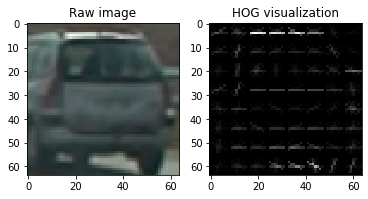

In [2]:
import cv2
from skimage.feature import hog
import numpy as np
pix_per_cell = 8
cell_per_block = 2
orient = 9

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False,
                     feature_vec=False):
                         
    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for 
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=True, 
                                  visualize= vis, feature_vector= feature_vec)
    
    
    
image = mpimg.imread(car_list[0])

features, hog_image = get_hog_features(image, orient, pix_per_cell, cell_per_block, True)
print(features.shape)

# plot example images with extracted HOG visualization
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image)
axarr[0].set_title('Raw image')
axarr[1].imshow(hog_image, cmap='gray')
axarr[1].set_title('HOG visualization')



In [3]:
def get_features_from_list(image_path_list):
    feature_list = []
    for image_path in image_path_list:
        image = mpimg.imread(image_path)
        feature_vec = get_hog_features(image, orient, pix_per_cell, cell_per_block)
        feature_list.append(np.ravel(feature_vec))
    return feature_list
    
car_features = get_features_from_list(car_list)
print(len(car_features))
print(car_features[0].shape)
not_car_features = get_features_from_list(not_car_list)
print(len(not_car_features))
print((not_car_features[0].shape))

# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(not_car_features))))

# Create an array stack of feature vectors
X = np.vstack((car_features, not_car_features)).astype(np.float64)
        



8792
(1764,)
8968
(1764,)


# Train a SVM classifier

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to both X_train and X_test
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

print(X_test.shape)

# Use a SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train_scaled, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test_scaled, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test_scaled[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

(3552, 1764)
9.77 Seconds to train SVC...
Test Accuracy of SVC =  0.9516
My SVC predicts:  [1. 1. 0. 0. 0. 0. 0. 1. 1. 0.]
For these 10 labels:  [1. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
0.00278 Seconds to predict 10 labels with SVC


/Users/erosen/miniconda3/envs/udacity/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [6]:
# Serialize the classifier
from joblib import dump, load
dump(svc, 'svc.joblib') 
dump(X_scaler, 'X_scaler.joblib')

['X_scaler.joblib']

In [11]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=10000).fit(X_train_scaled, y_train)

print('Test Accuracy of LogReg = ', round(clf.score(X_test_scaled, y_test),4))

t=time.time()
n_predict = 10
print('My LogisticRegression predicts: ', clf.predict(X_test_scaled[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with LogReg')

Test Accuracy of LogReg =  0.9564
My LogisticRegression predicts:  [1. 1. 0. 0. 0. 0. 0. 1. 1. 0.]
For these 10 labels:  [1. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
0.00183 Seconds to predict 10 labels with LogReg


# Implement Sliding Windows

In [41]:
from joblib import dump, load
import matplotlib.image as mpimg
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Deserialize the classifier
svc = load('svc.joblib') 
X_scaler = load('X_scaler.joblib') 

# Test classifier
img = mpimg.imread(car_list[7])
features = get_hog_features(img, orient, pix_per_cell, cell_per_block, False, True)
features = X_scaler.transform(np.reshape(features,(1,-1)))
test_prediction = svc.predict(features)


print(features.shape)
test_prediction

(1, 1764)


array([1.])

In [12]:
from typing import NamedTuple

class BoundingBox(NamedTuple):
    xleft: int
    xright: int
    ytop: int
    ybot: int

# Load image
img = mpimg.imread('test_images/test1.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    
    draw_img = np.copy(img)
    bb_list = []
    img_tosearch = img[ystart:ystop,:,:]
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        


    # Define blocks and steps as above
    nxblocks = (img_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (img_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog = get_hog_features(img_tosearch, orient, pix_per_cell, cell_per_block, vis = False, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_features = hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
 
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
   
            hog_features = X_scaler.transform(np.reshape(hog_features,(1,-1)))
            test_prediction = svc.predict(hog_features)

            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            if test_prediction == 1:
                bbox = BoundingBox(xleft=xbox_left, ytop=ytop_draw+ystart, ybot=ytop_draw+win_draw+ystart, xright=xbox_left+win_draw)
                bb_list.append(bbox)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
            #if test_prediction == 0:
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,0,0),6) 

    
    return draw_img, bb_list

def find_cars_multiscale(img, svc, X_scaler, orient, pix_per_cell, cell_per_block):

    ystart = 350
    ystop = 500
    scale = 1
    out_img_scale_1, bb_list_scale_1 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)

    ystart = 350
    ystop = 550
    scale = 1.5
    out_img_scale_1dot5, bb_list_scale_1dot5 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
  
    
    ystart = 350
    ystop = 600
    scale = 2
    out_img_scale_2, bb_list_scale_2 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)

    ystart = 450
    ystop = 650
    scale = 3
    out_img_scale_3, bb_list_scale_3 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)

    ystart = 500
    ystop = 700
    scale = 4
    out_img_scale_4, bb_list_scale_4 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)

    """
    f, axarr = plt.subplots(2,2,figsize=(15, 8))
    axarr[0,0].imshow(out_img_scale_1)
    axarr[0,0].set_title('scale 1')
    axarr[0,1].imshow(out_img_scale_2)
    axarr[0,1].set_title('scale 2')
    axarr[1,0].imshow(out_img_scale_3)
    axarr[1,0].set_title('scale 3')
    axarr[1,1].imshow(out_img_scale_4)
    axarr[1,1].set_title('scale 4')"""
    bb_list = bb_list_scale_1 + bb_list_scale_1dot5 + bb_list_scale_2 + bb_list_scale_3 + bb_list_scale_4
    return bb_list


# Create heatmap

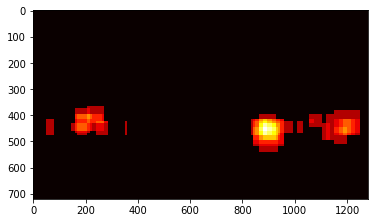

6 cars found


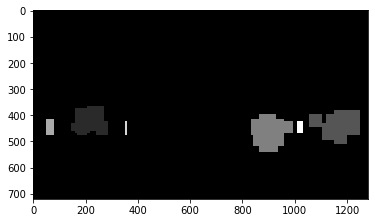

In [15]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box.ytop:box.ybot, box.xleft:box.xright] += 1

    # Return updated heatmap
    return heatmap

def cool_down(heatmap, cooldown_factor):
    heatmap[heatmap > 0] -= cooldown_factor
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


bb_list = find_cars_multiscale(img, svc, X_scaler, orient, pix_per_cell, cell_per_block)
heatmap = np.zeros(shape=img.shape[0:2], dtype=np.int8)
heatmap = add_heat(heatmap, bb_list)
heatmap = apply_threshold(heatmap, 2)

plt.imshow(heatmap, cmap='hot')
plt.show()


labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

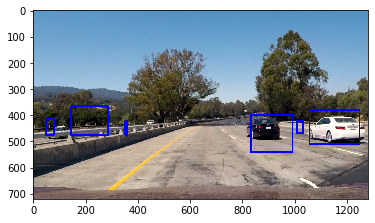

In [16]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(img), labels)
# Display the image
plt.imshow(draw_img)

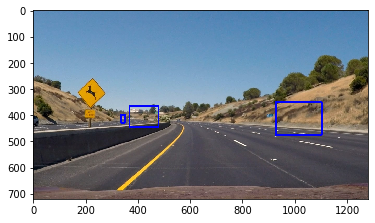

In [19]:
# All together
def find_car_pipeline(img, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    bb_list = find_cars_multiscale(img, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    heatmap = np.zeros(shape=img.shape[0:2], dtype=np.int8)
    heatmap = add_heat(heatmap, bb_list)
    heatmap = apply_threshold(heatmap, 3)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

# Load image
img = mpimg.imread('test_images/test2.jpg')
plt.imshow(find_car_pipeline(img, svc, X_scaler, orient, pix_per_cell, cell_per_block))

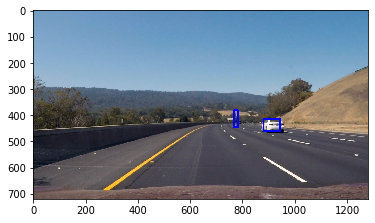

In [20]:
# Load image
img = mpimg.imread('test_images/test3.jpg')
plt.imshow(find_car_pipeline(img, svc, X_scaler, orient, pix_per_cell, cell_per_block))

In [2]:
# Load image
img = mpimg.imread('test_images/test4.jpg')
plt.imshow(find_car_pipeline(img, svc, X_scaler, orient, pix_per_cell, cell_per_block))

NameError: name 'find_car_pipeline' is not defined

In [3]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import CarFinder
from joblib import dump, load
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Deserialize the classifier
svc = load('svc.joblib') 
X_scaler = load('X_scaler.joblib') 

# set parameters
pix_per_cell = 8
cell_per_block = 2
orient = 9

#img = mpimg.imread('test_images/test4.jpg')
#cf = CarFinder.CarFinder(svc, X_scaler, orient, pix_per_cell, cell_per_block, img_size=img.shape[0:2])
#draw_img = cf.find_car_update(img)
#plt.imshow(draw_img)
#plt.show()

## Process video
video_output = 'output_test_video.mp4'
clip1 = VideoFileClip("test_video.mp4")
#initialize carfinder object
cf = CarFinder.CarFinder(svc, X_scaler, orient, pix_per_cell, cell_per_block, img_size=img.shape[0:2])
video_clip = clip1.fl_image(cf.find_car_update) #NOTE: this function expects color images!!

%time video_clip.write_videofile(video_output, audio=False)

t:   0%|          | 0/38 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_test_video.mp4.
Moviepy - Writing video output_test_video.mp4



Moviepy - Done !
Moviepy - video ready output_test_video.mp4
CPU times: user 16.1 s, sys: 721 ms, total: 16.8 s
Wall time: 19.8 s


In [4]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))